In [49]:
import pandas as pd
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams


import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler



from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit

# from keras.optimizers import RMSprop, adam

## Importing Data

In [50]:
day1_dataset_1min = pd.read_csv('Data Slices/5_days_timeseries_data/1min.csv')
day1_dataset_10min = pd.read_csv('Data Slices/5_days_timeseries_data/10min.csv')
day1_dataset_30min = pd.read_csv('Data Slices/5_days_timeseries_data/30min.csv')
day1_dataset_60min = pd.read_csv('Data Slices/5_days_timeseries_data/60min.csv')

In [51]:
def get_X_and_y(df, x_columns, y_columns):
    X = df[x_columns]
    y = df[y_columns]
    return X, y

In [52]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [53]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [54]:
def scale_dataset(sequences, columns = ['Price_USD', 'Price_Crypto', 'volume', 'density', 'vertex_count', 
                              'edge_count','vertext_edge_ratio'], fitted_scaler = None):
    collection_blacklist_dict = {sequence[0]:sequence[2] for sequence in sequences}
    concat_df = pd.concat([sequence[1] for sequence in sequences])
    if fitted_scaler is None:
        fitted_scaler = StandardScaler()
        fitted_scaler.fit(concat_df[columns])
    concat_df[columns] = fitted_scaler.transform(concat_df[columns])
    return  [(collection, group[columns], collection_blacklist_dict[collection]) 
             for collection, group in concat_df.groupby("collection")] , fitted_scaler

In [55]:
def get_all_sequences(all_df):
    sequence_dict = {}
    for df in all_df: 
        df = df.drop(['Unnamed: 0'], axis=1)
        x_columns =  ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','density',
                   'vertex_count','edge_count','collection']
        y_columns = ['blacklisted','collection']
        feature_columns=['Price_USD','Price_Crypto','volume',
                         'density', 'vertex_count','edge_count', 'collection', 'vertext_edge_ratio']
        X, y= get_X_and_y(df, x_columns, y_columns)
        X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']
        sequence_dict = get_daily_sequences(X, y, feature_columns, sequence_dict)
    return sequence_dict

In [56]:
def retrieve_all_train_test_sequences(all_df):
    train_test_sequences = []
    all_sequence_dict = list(get_all_sequences(all_df).items())
    
    x = [sequence for sequence in all_sequence_dict]
    y = [sequence[1][1] for sequence in all_sequence_dict]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
         
    for train, test in  sss.split(x, y):
        X_train = [x[idx] for idx in train]
        X_test = [x[idx] for idx in test]
    return X_train, X_test

In [57]:
train_sequences, test_sequences = retrieve_all_train_test_sequences([day1_dataset_1min, day1_dataset_10min,
                                                                     day1_dataset_30min,
                                                                     day1_dataset_60min])

<ipython-input-55-ba7f0a36a736>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']


In [58]:
def scale_train_test_sequences(train_sequences, test_sequences):
    scaled_train_dataset_dict = {}
    scaled_test_dataset_dict = {}
    scaled_train_dataset= []
    scaled_test_dataset= []
    length = len(train_sequences[0][1][0])
    for n in range(length):
        train_scaled, scaler = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                              train_sequences])
        test_scaled, _ = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                        test_sequences],
                      fitted_scaler= scaler)
        scaled_train_dataset.append(train_scaled)
        scaled_test_dataset.append(test_scaled)

    for scale_sequence in scaled_train_dataset:
        for collection in scale_sequence:
            if scaled_train_dataset_dict.get(collection[0]):
                scaled_train_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_train_dataset_dict[collection[0]] = ([collection[1]], collection[2])

    for scale_sequence in scaled_test_dataset:
        for collection in scale_sequence:
            if scaled_test_dataset_dict.get(collection[0]):
                scaled_test_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_test_dataset_dict[collection[0]] = ([collection[1]], collection[2])
                
    return list(scaled_train_dataset_dict.values()), list(scaled_test_dataset_dict.values())

In [59]:
train_values, test_values = scale_train_test_sequences(train_sequences,test_sequences)

In [60]:
test_values[7][0][0]

,Price_USD,Price_Crypto,volume,density,vertex_count,edge_count,vertext_edge_ratio
144000,-0.186885,-0.150723,2.619925,0.851607,-0.125652,-0.079606,0.738635
144001,-0.186885,-0.150723,-0.046410,0.851607,-0.125652,-0.079606,0.738635
144002,-0.186885,-0.150723,-0.046410,0.851607,-0.125652,-0.079606,0.738635
144003,-0.186885,-0.150723,-0.046410,0.851607,-0.125652,-0.079606,0.738635
144004,-0.186885,-0.150723,-0.046410,0.851607,-0.125652,-0.079606,0.738635
...,...,...,...,...,...,...,...
151195,-0.190200,-0.152215,-0.046410,0.851607,-0.125652,-0.079606,0.738635
151196,-0.190200,-0.152215,-0.046410,0.851607,-0.125652,-0.079606,0.738635
151197,-0.190200,-0.152215,-0.046410,0.851607,-0.125652,-0.079606,0.738635
151198,-0.190200,-0.152215,-0.046410,0.851607,-0.125652,-0.079606,0.738635


In [61]:
train_values[356][0][0]

,Price_USD,Price_Crypto,volume,density,vertex_count,edge_count,vertext_edge_ratio
3268800,3.294496,0.737258,2.619925,-1.707484,11.108457,12.559371,-3.748147
3268801,2.803107,0.611197,21.284269,-1.707454,11.090332,12.551004,-3.748899
3268802,2.334790,0.491055,42.614949,-1.707404,11.056942,12.529924,-3.749934
3268803,2.538493,0.543313,29.283274,-1.707345,11.016875,12.502729,-3.751060
3268804,2.119672,0.435869,15.951599,-1.707317,10.993979,12.480844,-3.751308
...,...,...,...,...,...,...,...
3275995,-0.211124,-0.161973,-0.046410,-1.707503,11.123721,12.572245,-3.747879
3275996,-0.143625,-0.135803,2.619925,-1.707506,11.123721,12.569670,-3.747717
3275997,-0.143625,-0.135803,-0.046410,-1.707506,11.123721,12.569670,-3.747717
3275998,-0.190390,-0.155199,2.619925,-1.707508,11.123721,12.567095,-3.747556


## Model

In [62]:
train_values = list(scaled_train_dataset_dict.values())

NameError: name 'scaled_train_dataset_dict' is not defined

In [ ]:
test_values = list(scaled_test_dataset_dict.values())

In [24]:
len(train_values[0][0])

4

In [25]:
for n in range(len(train_values[0][0])):
    print(n)

0
1
2
3


In [63]:
model_shapes = [train_values[0][0][n].shape for n in range(len(train_values[0][0]))]

In [64]:
model_shapes

[(7200, 7), (720, 7), (240, 7), (120, 7)]

In [65]:
filters = [200,200,200,200]
k_sizes = [100,10,6,4]

In [67]:
def get_base_model(shape, k_size = k_sizes[0], num_filters = filters[0]):
    print("base model shape", shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #todo: fix maxpooling
#     processed = MaxPooling1D(pool_size=2, strides=1, padding='same')(convolved)
    compressed = Dense(100, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    model.summary()
    return model

In [68]:
def main_model(shapes, filters, k_sizes):
    inputs = [Input(shape=shape, name=f'input{n}')for n, shape in enumerate(shapes)]
    sub_models = [ get_base_model(shape, k_size = k_sizes[n], num_filters=filters[n]) 
                  for n, shape in enumerate(shapes)]
    print(sub_models[0].output)
    embeddings = [ model(inputs[n]) for n, model in enumerate(sub_models)]
    merged = Concatenate()(embeddings)
    #todo: tweak dense be modifiable 
    layer1 = Dense(100, activation='relu', name ='hidden_layer1')(merged)
    layer2 = Dense(50, activation='relu', name ='hidden_layer2')(layer1)
    layer3 = Dense(25, activation='relu', name ='hidden_layer3')(layer2)
    out = Dense(1, activation='sigmoid')(layer3)
    model = Model(inputs=inputs, outputs=out)
    return model

In [69]:
def run_model(train, validation, model_shapes, filters, k_sizes):
    es = keras.callbacks.EarlyStopping(min_delta=0.00001, patience=20)
    model = main_model(model_shapes, filters, k_sizes)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='adam', #sgd, nadam, adam, rmsprop
                          metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                   tf.keras.metrics.AUC(curve='PR')])
    model.summary()
    model_hist = model.fit(train,
                               validation_data=validation,
                               batch_size=200, epochs=2000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [70]:
def get_formatted_inputs(values):
    x_train_arr = []
    length = len(values)
    for n in range(len(values[0][0])):
        x_train = [sequence[0][n] for sequence in values]
        shape = x_train[0].shape
        x_train =  np.stack(x_train)
        x_train = x_train.reshape(length, shape[0], shape[1])
        x_train_arr.append(x_train)
    return x_train_arr, [sequence[1] for sequence in values]

In [71]:
def retrieve_tensor_datasets(train, test):
    formatted_train = ({f'input{n}': data for n, data in enumerate(train[0]) }, train[1])
    formatted_test = ({f'input{n}': data for n, data in enumerate(test[0]) }, test[1])
    train_dataset = tf.data.Dataset.from_tensor_slices(formatted_train).batch(200)
    test_dataset = tf.data.Dataset.from_tensor_slices(formatted_test).batch(200)
    return train_dataset, test_dataset

In [72]:
dataset, validation = retrieve_tensor_datasets(get_formatted_inputs(train_values),
                                               get_formatted_inputs(test_values) )

In [73]:
model_hist, model = run_model(dataset, validation, model_shapes, filters, k_sizes)

base model shape (7200, 7)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7200, 7)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7200, 200)         140200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
Total params: 160,300
Trainable params: 160,300
Non-trainable params: 0
_________________________________________________________________
base model shape (720, 7)
Model: "model_1"
___________________________________________________

Epoch 3/2000
4/4 [==============================] - 35s 9s/step - loss: 0.5695 - binary_accuracy: 0.7233 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3726 - val_loss: 0.5613 - val_binary_accuracy: 0.7236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3671
Epoch 4/2000
4/4 [==============================] - 34s 9s/step - loss: 0.5565 - binary_accuracy: 0.7245 - precision: 1.0000 - recall: 0.0045 - auc: 0.4139 - val_loss: 0.5571 - val_binary_accuracy: 0.7236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3526
Epoch 5/2000
4/4 [==============================] - 34s 9s/step - loss: 0.5422 - binary_accuracy: 0.7233 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4426 - val_loss: 0.5556 - val_binary_accuracy: 0.7236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3598
Epoch 6/2000
4/4 [==============================] - 35s 9s/step - loss: 0.5462 - binary_accuracy: 0.7258 - precision: 1.0000 - recall: 0.0091 - auc: 0.4195 

4/4 [==============================] - 41s 10s/step - loss: 0.4010 - binary_accuracy: 0.8151 - precision: 0.7589 - recall: 0.4864 - auc: 0.7284 - val_loss: 0.6034 - val_binary_accuracy: 0.7085 - val_precision: 0.4348 - val_recall: 0.1818 - val_auc: 0.4562
Epoch 34/2000
4/4 [==============================] - 38s 9s/step - loss: 0.3902 - binary_accuracy: 0.8239 - precision: 0.8175 - recall: 0.4682 - auc: 0.7438 - val_loss: 0.6046 - val_binary_accuracy: 0.7236 - val_precision: 0.5000 - val_recall: 0.2000 - val_auc: 0.4652
Epoch 35/2000
4/4 [==============================] - 37s 10s/step - loss: 0.3876 - binary_accuracy: 0.8151 - precision: 0.8017 - recall: 0.4409 - auc: 0.7542 - val_loss: 0.6107 - val_binary_accuracy: 0.7286 - val_precision: 0.5200 - val_recall: 0.2364 - val_auc: 0.4724


In [ ]:
prediction[prediction <=0.5] = 0
prediction[prediction >0.5] = 1

In [ ]:
[pred[0] for pred in prediction.tolist()]

In [74]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['binary_accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['binary_accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [82]:
def plot_training_curves_auc(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc'] + history.history['auc']),
                        max(history.history['val_auc'] + history.history['auc']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc'], label = 'auc')
    ax[1].plot(index, history.history['val_auc'], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

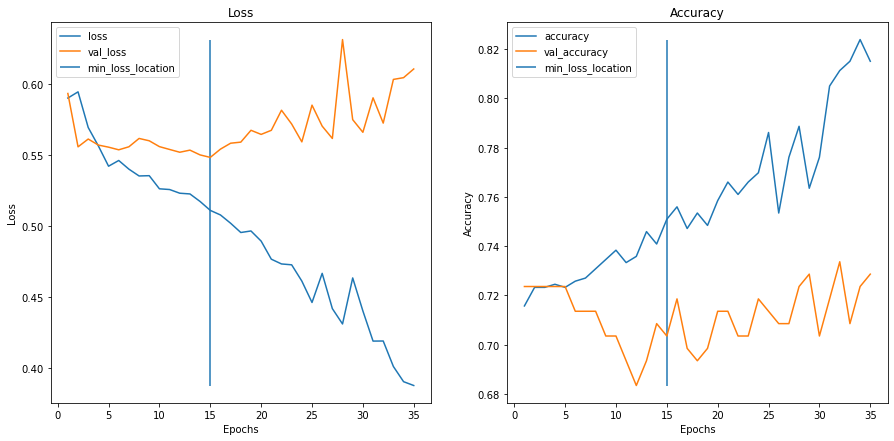

In [76]:
plot_training_curves(history=model_hist)

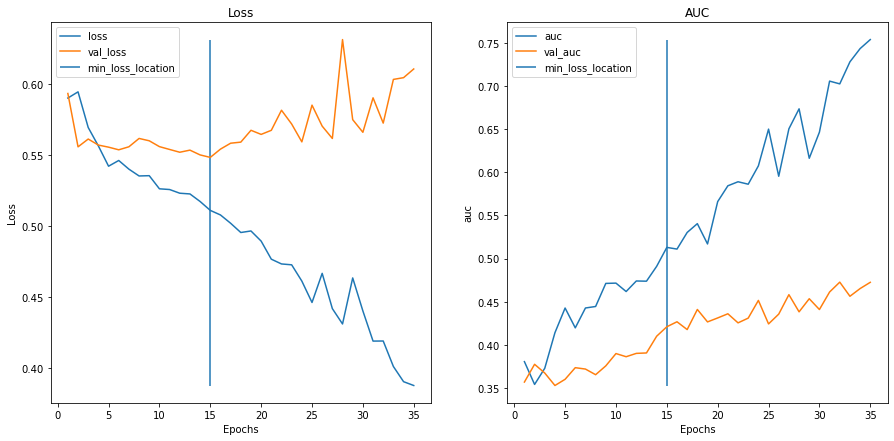

In [83]:
plot_training_curves_auc(history=model_hist)